# Fitting Gaussian Mixture on a data sample using features from a pre-trained Model

Consider the set of all $K$-dimensional categorical distributions given by

\begin{equation}
    \mathcal{C} = \bigg\{ \mathbf{c} \in \mathbb{R}^{K}_{+} :  \mathbf{c} \geq 0,\ \mathbf{c}^{\rm T}\mathbf{1} = 1 \bigg\} \subset \mathbb{R}^{K}_{+}.
\end{equation}

In this code we consider the set of gaussian mixtures for the set of distributions $\{ \nu_{i} \}_{i = 1}^{K} $ given by given by:
\begin{equation}
		\mathcal{GM} \bigg(\mathbf{c}, \{ \nu_{i} \}_{i = 1}^{K} \bigg) = \bigg\{ \sum_{i = 1}^{K} c_{i} \nu_{i}, \ \forall \mathbf{c} \in \mathcal{C} \bigg\}
	\end{equation}
For the mixture of gaussian distributions $\{ \nu_{i} \}_{i = 1}^{K} $ with means $\{ \mu_{i} \}_{i = 1}^{K} $ and covariance matrices $\{ \Sigma_{i} \}_{i = 1}^{K} $, mixture means and covariance are


\begin{gather*}
 \bar{\mu}_{\mathbf{c}} = \sum_{k =1}^{K} c_{k} \mu_{k}\  \text{,  }
 \,\,\,\, \tilde{\Sigma}_{\mathbf{c}} = \sum_{k =1}^{K} c_k \big( \Sigma_k + \mu_{k} \mu_{k}^{\top} - \bar{\mu}_{\mathbf{c}} \bar{\mu}_{\mathbf{c}}^\top \big)
\end{gather*}

For a data sample $\nu_{*}$, we employed Frank-Wolfe Based optimization routine to find the best matching mean, covaraince pair from the the set of all possible mixtures of $\{ \nu_{i} \}_{i = 1}^{K} $ to fit with mean  and covaraince of $\nu_{*}$.

In [1]:
#%%
import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy.optimize import approx_fprime
from matplotlib import pyplot as plt

'''
    mx: mean of source with size: n x 1
    M: means of target distributions with size: n x K, where K indicates number of data-classes.
    covx: covariance matrix of source with size: n x 1
    covM: array of covariance matrices of target distributions with size: K x n x n, where K indicates number of data-classes.
    max_iter: max_iterations of Frank Wolfe
    tol: tolerance for gradient check
    divg: divergences to be used for computations
    max_iter: maximum of frank wolfe iterations
    min_tol: minimum tolerance for gardient checking
    print_iter: priniting values of maixture weights for each iteration
'''
class GM_FW:
    def __init__(self, mux, M, covx, covM, c0, max_iter = None, min_tol = None, print_iter = None):
        # instance attributes which should be initilzied with class
        self.mux = mux
        self.M = M
        self.covx = covx
        self.covM = covM
        self.c0 = c0

        
        self.sqrt_covx = np.real(sp.linalg.sqrtm(covx))
        self.sqrt_covx = (self.sqrt_covx + self.sqrt_covx.T) /2
        
        self.I = np.identity(np.size(mux), dtype=np.float64)

        # attributes to be keep track of computations
        self.c = np.zeros_like(c0, dtype=np.float64)
        self.mubar = np.zeros_like(mux, dtype=np.float64)
        self.hat_covM = self.covM + self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]) @ self.M.T.reshape([M.shape[1], 1, M.shape[0]])
        self.tilde_covM = np.zeros_like(covM, dtype=np.float64)
        self.tilde_sigma_c = np.zeros([covM.shape[1], covM.shape[2]],dtype=np.float64)
        self.zeta_c = np.zeros([covM.shape[1], covM.shape[2]], dtype=np.float64)
        
        if max_iter == None:
            self.max_iter = 1000
        else:
            self.max_iter = max_iter

        if min_tol == None:
            self.min_tol = 1e-6
        else:
            self.min_tol = min_tol
        
        if print_iter == None:
            self.print_iter = False
        elif print_iter == False:
            self.print_iter = False
        elif print_iter == True:
            self.print_iter = True
        else:
            self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter], dtype=np.float64)
        self.grads = np.zeros([self.max_iter, np.size(self.c)], dtype=np.float64)
        self.weights = np.zeros([self.max_iter, np.size(self.c)], dtype=np.float64)
        
    
    def reset_values(self):
        # self.mux = mux
        # self.M = M
        # self.covx = covx
        # self.covM = covM
        # self.c0 = c0
        # self.divg = divg

        self.sqrt_covx = sp.linalg.sqrtm(self.covx)
        self.sqrt_covx = (self.sqrt_covx + self.sqrt_covx.T) /2
        self.I = np.identity(np.size(self.mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(self.c0)
        self.mubar = np.zeros_like(self.mux)
        self.hat_covM = self.covM + \
            self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]
                         ) @ self.M.T.reshape([self.M.shape[1], 1, self.M.shape[0]])
        self.tilde_covM = np.zeros_like(self.covM)
        self.tilde_sigma_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])
        self.zeta_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])

        # if max_iter == None:
        #     self.max_iter = 1000
        # else:
        #     self.max_iter = max_iter

        # if min_tol == None:
        #     self.min_tol = 1e-6
        # else:
        #     self.min_tol = min_tol

        # if print_iter == None:
        #     self.print_iter = False
        # elif print_iter == False:
        #     self.print_iter = False
        # elif print_iter == True:
        #     self.print_iter = True
        # else:
        #     self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])
        

    def initialize_weights(self):
        self.c = self.c0

    def update_mubar(self):
        self.mubar =  np.sum(self.c[np.newaxis,:] * self.M, axis = 1, keepdims = True)
    
    def compute_mmd(self):
        return np.linalg.norm(self.mux - self.M@self.c)**2
    
    def compute_mmd_grad(self):
        return 2*self.M.T @ (self.M @ self.c[:,np.newaxis] - self.mux)

    def update_tilde_covM(self):
        self.tilde_covM = self.hat_covM - (self.mubar@self.mubar.T)[np.newaxis,:,:]

        
    def update_tilde_sigma_c(self):
        self.tilde_sigma_c = np.sum(
            self.c[:, np.newaxis, np.newaxis] * self.tilde_covM, axis=0)
            
    def update_zeta_c(self):
        temp = np.real(sp.linalg.sqrtm(self.sqrt_covx @ self.tilde_sigma_c @ self.sqrt_covx) )
        self.zeta_c = (temp + temp.T)/2

    def compute_bures(self):
        temp =  np.trace( self.covx + self.tilde_sigma_c - 2 * self.zeta_c )
        return temp

    
    
    def compute_bures_grad_tilde_sigma_c(self):
        return self.I - self.sqrt_covx @ sp.linalg.pinv(self.zeta_c) @ self.sqrt_covx
    
    def compute_bures_grad_c(self):
        G = self.compute_bures_grad_tilde_sigma_c()
        rho = (self.M.T.reshape(self.M.shape[1], self.M.shape[0],1) @ self.mubar.T) + self.mubar @ self.M.T.reshape(self.M.shape[1],1,self. M.shape[0])
        temp = np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))[:, np.newaxis]
        return temp
    
    def compute_frechet(self):
        B = self.compute_bures()
        mmd = self.compute_mmd()
        return B + mmd

    def compute_frechet_grad(self):
        GB = self.compute_bures_grad_c()
        Gmmd = self.compute_mmd_grad()
        return GB + Gmmd


    def FW_frechet_routine(self):
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()
            self.update_zeta_c()
            self.compute_bures_grad_c()
            self.obj_vals[i] = self.compute_frechet()
            g = self.compute_frechet_grad()
            #print(g)
            self.grads[i, :] = np.squeeze(g)
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            
            self.weights[i, :] = self.c
            if self.print_iter == True:
                print("iter = ",i)
                print(self.c)
    
    def FW_bures_routine(self):

        #commented part must be uncommented for gradient-checking
        
        def bures_grad_num(c_i, epsilon):
            
            num_grad = np.zeros_like(c_i)
            I = np.identity(c_i.size)
            for i in range(0, num_grad.size):
                num_grad[i] = (bures(c_i + epsilon * I[:,i]) - bures(c_i) ) / epsilon
            
            return num_grad
            

        def bures(c_i):
            
            mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)
            # k, n, n - n,n => k,n,n
            tilde_covM = self.hat_covM 
            #k,.,. * k,n,n => n,n
            tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0) - mubar@mubar.T

            #n,n
            zeta_ci = np.real(sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx))

            #n,n
            zeta_ci = (zeta_ci + zeta_ci.T)/2

            #scalar
            temp =  np.trace( tilde_sigma_c + self.covx  - 2 * zeta_ci )
            return temp
        
        def bures_grad(c_i):

            mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)

            tilde_covM = self.hat_covM - (mubar@mubar.T)[np.newaxis,:,:]

            tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0)

            zeta_ci = np.real(sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx))
            zeta_ci = (zeta_ci + zeta_ci.T)/2

            G = self.I - self.sqrt_covx @ np.linalg.pinv(zeta_ci) @ self.sqrt_covx

            rho = (M.T.reshape(M.shape[1],M.shape[0],1) @ mubar.T) +  mubar @ M.T.reshape(M.shape[1],1,M.shape[0])

            return np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))
            

        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()
            self.update_zeta_c()
            self.obj_vals[i] = self.compute_bures()
            g = self.compute_bures_grad_c()
            
            print("g")
            print(np.squeeze(g))
            c_i = self.c
            
            # print(np.squeeze(bures_grad(c_i)))
            # #  print(np.squeeze(self.compute_bures_grad_c()))

            eps = np.sqrt(np.finfo(np.float64).eps)
            # #eps = 100*(np.finfo(np.float64).eps)
            # eps = 1e-8
            ga = sp.optimize.approx_fprime(c_i, bures, np.array(eps*np.ones(np.size(g))).T)
            #ga = bures_grad_num(c_i, eps)
            print("ga")
            print(ga)
            
            #print(sp.optimize.check_grad(bures, bures_grad, c_i))
            
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            self.grads[i, :] = np.squeeze(g)
            self.weights[i, :] = self.c

            if self.print_iter == True:
                print("iter =  ",i)
                print(self.c)

    def FW_MMD_routine(self):
        
        # commented part must be uncommented for gradient-checking
        
        def mmd(c_i):
            return (np.linalg.norm(self.M@c_i[:,np.newaxis] - self.mux))**2

        def mmd_grad(c_i):
            return np.squeeze(2 * self.M.T @ (self.M @ c_i[:,np.newaxis] - self.mux))
        
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.obj_vals[i] = self.compute_mmd()

            g = self.compute_mmd_grad()

            # print("g")
            # print(np.squeeze(g))
            # c_i = self.c
            # # print(np.squeeze(mmd_grad(c_i)))
            # # #print(np.squeeze(self.compute_mmd_grad()))

            # eps = np.sqrt(np.finfo(float).eps)
            
            # print("ga")
            # ga = sp.optimize.approx_fprime(c_i, mmd, np.array(eps*np.ones(np.size(g))).T)
            # print(ga)

            #print(sp.optimize.check_grad(mmd, mmd_grad, c_i))

            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c  + gamma * s 
            self.grads[i,:] = np.squeeze(g)
            self.weights[i,:] = self.c

            if self.print_iter == True:
                print("iter = ",i)
                print(self.c)


def Hellinger(p, q):
  '''
  Function to evaluate Hellinger Distance between distributions categorical distributions p and q
  input: distributions p and q
  outputs: Hillnger distance between p and q

  '''
  assert np.all(p >= 0), "first distribution must be non-negative"
  assert np.all(q >= 0), "second distribution must be non-negative"
  assert p.size == q.size, "input vectors must be of same size"

  p = p.reshape([p.size, 1])
  q = q.reshape([q.size, 1])

  return (1/np.sqrt(2)) * np.linalg.norm(np.sqrt(p) - np.sqrt(q))


In [2]:
import numpy as np
import scipy as sp

M = np.array([[0, -0.5, 0.5],[1, 0, 0]])
#M = np.array([[0, 0, 0], [0, 0, 0]])
#M = np.ones_like(M)
mux = np.array([[np.sqrt(3)/2], [np.sqrt(3)/2] ])
covx = np.array([[10,6],[6,8]])

# mux = np.mean(M, axis = 1, keepdims = 0)
covM = np.zeros([3,2,2])
covM[0] = np.array([[1, 0.5],[0.5, 1]]) 
covM[1] = np.array([[5, 0.6], [0.6, 7]])
covM[2] = np.array([[4, 1], [1, 2]])
# covx = (covM[0] + covM[1] + covM[2])/3
c0 = np.ones(3)/3
 
iterations = 10

test = GM_FW(mux, M, covx, covM, c0, max_iter = iterations, print_iter = True)
test.reset_values()
test.FW_bures_routine()
#test.FW_frechet_routine()



g
[-1.45464757 -6.04156737 -3.76714248]
ga
[-1.45464742 -6.04156721 -3.76714194]
iter =   0
[0. 1. 0.]
g
[-1.03509689 -1.75706954 -2.1356066 ]
ga
[-1.035097   -1.75706959 -2.13560677]
iter =   1
[0.         0.33333333 0.66666667]
g
[-1.2742634  -4.72620224 -2.92685718]
ga
[-1.27426279 -4.72620213 -2.92685711]
iter =   2
[0.         0.66666667 0.33333333]
g
[-1.06179005 -2.86371089 -2.39419786]
ga
[-1.06179011 -2.86371148 -2.39419818]
iter =   3
[0.  0.8 0.2]
g
[-1.03561939 -2.35690899 -2.26366302]
ga
[-1.03561878 -2.3569082  -2.26366258]
iter =   4
[0.         0.86666667 0.13333333]
g
[-1.03083879 -2.13795423 -2.21237434]
ga
[-1.03083813 -2.13795352 -2.21237421]
iter =   5
[0.         0.61904762 0.38095238]
g
[-1.0774347  -3.07073116 -2.45063399]
ga
[-1.07743442 -3.07073104 -2.45063305]
iter =   6
[0.         0.71428571 0.28571429]
g
[-1.04965327 -2.67115124 -2.34309394]
ga
[-1.04965353 -2.67115188 -2.34309399]
iter =   7
[0.         0.77777778 0.22222222]
g
[-1.03836063 -2.43465597 -2

In [3]:
num_ptx = 10
dim = 100

np.random.seed(2021)
M = np.random.rand(dim, num_ptx)
#M = np.zeros([dim, num_ptx])
#M = np.ones_like(M)
mux = np.random.rand(dim).reshape([dim, 1])
A = np.random.rand(dim, dim)
covx = A @ A.T
covM = np.zeros([num_ptx, dim, dim])
for i in range(0, num_ptx):
    A = np.random.rand(dim, dim)
    covM[i] = A @ A.T +  0 * np.identity(dim)

iterations = 10

c0 = np.ones(num_ptx)/(num_ptx)
test = GM_FW(mux, M, covx, covM, c0, max_iter=iterations, print_iter = True)
#test.reset_values()
test.FW_bures_routine()


g
[131.78478908 124.80934282 138.28859042 120.98625841 134.69296324
 121.94296326 119.74914852 119.41750775 131.74584938 127.89016922]
ga
[131.50952148 124.0515976  138.21163559 120.38177109 133.5706749
 121.866539   119.54069138 118.69256592 131.35587311 127.63020325]
iter =   0
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
g
[-754.41526927 -749.42806303 -702.68464944 -728.95897895 -701.02230022
 -787.1796086  -728.16284345  195.03671339 -715.76265185 -683.55267196]
ga
[-722.10423279 -700.56184006 -654.7858429  -754.05873108 -646.08842087
 -771.4319458  -683.09476471  211.75753784 -680.73534012 -657.09510422]
iter =   1
[0.         0.         0.         0.         0.         0.66666667
 0.         0.33333333 0.         0.        ]
g
[-20.61759858 -38.23502648  -4.88218065 -39.38048373 -19.99070089
 200.83788451 -47.05030243 105.04407249 -19.26296471 -25.23526756]
ga
[-20.33437347 -36.66832733  -5.47698212 -38.86569977 -19.63662338
 200.3463974  -46.09080505 106.53300476 -18.23244095 -25.38471985]
i

In [4]:
# for i in range(0, covM.shape[0]):
#     print(np.all(covM[i ]== covM[i].T))
#     print(np.linalg.eigvalsh(covM[i]))

# Testing on MNIST Data-set with PCA

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from numpy.random import exponential
from sklearn.decomposition import PCA

# np.random.seed(2021)

# Data Processing before PCA 
# N_samples indicates the number of samples to be drawn from data
N_samples = 500
# sample_sz indicates the number of samples to be drawn from data
sample_sz = 400

tf.keras.datasets.mnist.load_data(path="mnist.npz")
(X_train, y), (X_test, yt) = keras.datasets.mnist.load_data()

X_train = X_train / 255
y = y / 1
X_test = X_test / 255
yt = yt / 1

X = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
Xt = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# PCA from scikit-learn
PCA_components = 130
pca = PCA(n_components = PCA_components)
pca.fit(X)
# np.sum(pca.explained_variance_ratio_)
P = pca.components_
X_hat = X@P.T
Xt_hat = Xt@P.T

# Creation and Testing and Training samples

n_classes = np.size(np.unique(y))
means_i = np.zeros([n_classes, PCA_components])
covs_i = np.zeros([n_classes, PCA_components, PCA_components])

Training_Data = {}
Training_Lables = {}
for i in range(0, 10):
  Training_Data[str(i)] = X_hat[y == i]
  Training_Lables[str(i)] = y[y == i]
  means_i[i] = np.mean(Training_Data[str(i)], axis = 0)
  covs_i[i] = np.cov(Training_Data[str(i)].T)

Testing_Data = {}
Testing_Lables = {}
for i in range(0, 10):
  Testing_Data[str(i)] = Xt_hat[yt == i]
  Testing_Lables[str(i)] = yt[yt == i]

FW_iterations = 1000
Hellinger_metric = np.zeros([N_samples, FW_iterations])
Grads = np.zeros([N_samples, FW_iterations, n_classes])
Optimal_weights = np.zeros([N_samples, FW_iterations, n_classes])
Sample_distributions = np.zeros([N_samples, n_classes])

for sample_iter in range(0, N_samples): 
  # sampling uniformly on probability simplex
  sz = exponential(1, n_classes)
  s = sz / np.sum(sz)
  ints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  p = s
  counts_sample = np.floor(sample_sz * p)
  Sample_distributions[sample_iter,:] = counts_sample / np.sum(counts_sample)

  sample = np.empty([0, PCA_components], dtype = float)
  sample_labels = np.empty(0, dtype = float)
  counter = 0
  for k in ints:
    idx = np.random.choice(np.arange(0, Testing_Data[str(k)].shape[0]), size = np.int(counts_sample[counter]), replace = False )
    sample = np.append(sample, Testing_Data[str(k)][idx], axis = 0)
    sample_labels = np.append(sample_labels, Testing_Lables[str(k)][idx], axis = 0)
    counter = counter + 1

  mean_x = np.mean(sample, axis = 0)
  covx = np.cov(sample.T)

  mux = mean_x[np.newaxis,:].T
  M = means_i.T
  covM = covs_i
  
  # Frank_Wolfe is invoked
  c0 = np.ones(n_classes)/n_classes
  
  MNIST = GM_FW(mux, M, covx, covM, c0, max_iter = FW_iterations, print_iter = False)
  
  MNIST.FW_frechet_routine()
  Optimal_weights[sample_iter] = MNIST.weights
  Grads[sample_iter] = MNIST.grads
  print("sample = ", sample_iter)

for i in range(0, N_samples):
    for j in range(0, FW_iterations):
        Hellinger_metric[i, j] = Hellinger(Sample_distributions[i], Optimal_weights[i, j, :])

from tempfile import TemporaryFile
MNIST_data = TemporaryFile()
np.savez("MNIST_data", Optimal_weights=Optimal_weights, Grads=Grads, \
         Sample_distributions=Sample_distributions, Hellinger_metric=Hellinger_metric)


sample =  0
sample =  1
sample =  2
sample =  3
sample =  4
sample =  5
sample =  6
sample =  7
sample =  8
sample =  9
sample =  10
sample =  11
sample =  12
sample =  13
sample =  14
sample =  15
sample =  16


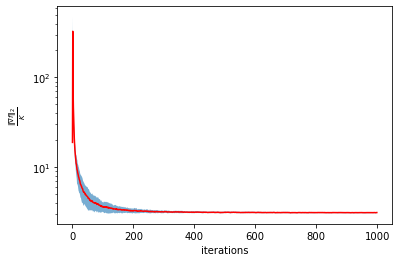

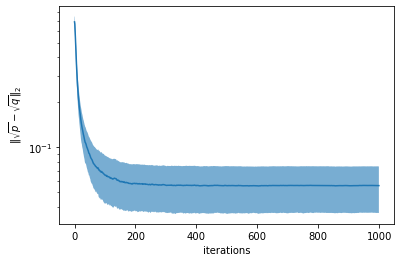

In [14]:
fig, ax = plt.subplots()


iters = np.array([k for k in range(0, FW_iterations )])
Grads_norms = np.linalg.norm(Grads/n_classes, axis=0)
Grads_norms_means = np.mean(Grads_norms, axis = 1)
Grads_norms_std = np.std(Grads_norms, axis=1)
plt.semilogy(iters, Grads_norms_means, color = 'r')
plt.fill_between(iters, Grads_norms_means - Grads_norms_std,
                Grads_norms_means + Grads_norms_std, alpha = 0.6)
plt.xlabel("iterations")
plt.ylabel('$ \\frac{\Vert\\nabla f \Vert_{2}}{K}$')
plt.show()

Hellinger_means = np.mean(Hellinger_metric.T, axis=1)
Hellinger_std = np.std(Hellinger_metric.T, axis=1)
#plt.semilogy(iters, (Hellinger_metric.T))
plt.semilogy(iters, Hellinger_means)

plt.fill_between(iters, Hellinger_means - Hellinger_std,
                 Hellinger_means + Hellinger_std, alpha=0.6)
plt.xlabel("iterations")
plt.ylabel(
    "$\ \Vert \sqrt{p} - \sqrt{q} \Vert_{2}$")
plt.show()


CIFAR-Data with Inception-net 

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np
# from numpy.random import exponential

# import pickle

# def LoadFile(file_name):
#   with open(file_name,'rb') as f:
#     data = pickle.load(f)
#   return data


# # Data Processing before PCA 
# # N_samples indicates the number of samples to be drawn from data
# N_samples = 1
# Hellinger_distances = np.zeros([N_samples, 1])
# # sample_sz indicates the number of samples to be drawn from data
# sample_sz = 500

# X = LoadFile('x_train_Cifar10_inception_2048.pkl')
# Xt = LoadFile('x_test_Cifar10_inception_2048.pkl')
# y = LoadFile('y_train_Cifar10_inception_2048.pkl')
# yt = LoadFile('y_test_Cifar10_inception_2048.pkl')
# y = np.squeeze(y)
# yt = np.squeeze(yt)

# n_classes = np.size(np.unique(y))
# means_i = np.zeros([n_classes, X.shape[1]])
# covs_i = np.zeros([n_classes,X.shape[1], X.shape[1]])

# Training_Data = {}
# Training_Lables = {}
# for i in range(0, 10):
#   Training_Data[str(i)] = X[y == i]
#   Training_Lables[str(i)] = y[y == i]
#   means_i[i] = np.mean(Training_Data[str(i)], axis = 0)
#   covs_i[i] = np.cov(Training_Data[str(i)].T)

# Testing_Data = {}
# Testing_Lables = {}
# for i in range(0, 10):
#   Testing_Data[str(i)] = Xt[yt == i]
#   Testing_Lables[str(i)] = yt[yt == i]

# FW_iterations = 1
# Hellinger_metric = np.zeros([N_samples, FW_iterations])
# Grads = np.zeros([N_samples, FW_iterations, n_classes])
# Optimal_weights = np.zeros([N_samples, FW_iterations, n_classes])
# Sample_distributions = np.zeros([N_samples, n_classes])

# for sample_iter in range(0, N_samples): 
#   # sampling uniformly on probability simplex
#   sz = exponential(1, n_classes)
#   s = sz / np.sum(sz)
#   ints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#   p = s
#   counts_sample = np.floor(sample_sz * p)
#   Sample_distributions[sample_iter,:] = counts_sample / np.sum(counts_sample)

#   sample = np.empty([0, X.shape[1]], dtype = float)
#   sample_labels = np.empty(0, dtype = float)
#   counter = 0
#   for k in ints:
#     idx = np.random.choice(np.arange(0, Testing_Data[str(k)].shape[0]), size = np.int(counts_sample[counter]), replace = False )
#     sample = np.append(sample, Testing_Data[str(k)][idx], axis = 0)
#     sample_labels = np.append(sample_labels, Testing_Lables[str(k)][idx], axis = 0)
#     counter = counter + 1

#   mean_x = np.mean(sample, axis = 0)
#   covx = np.cov(sample.T)

#   mux = mean_x[np.newaxis,:].T
#   M = means_i.T
#   covM = covs_i
  
#   # Frank_Wolfe is invoked
#   c0 = np.ones(n_classes)/n_classes
  
#   MNIST = GM_FW(mux, M, covx, covM, c0, max_iter = FW_iterations, print_iter = False)
  
#   MNIST.FW_bures_routine()
#   Optimal_weights[sample_iter] = MNIST.weights
#   Grads[sample_iter] = MNIST.grads
#   print("sample = ", sample_iter)

# for i in range(0, N_samples):
#     for j in range(0, FW_iterations):
#         Hellinger_metric[i, j] = Hellinger(Sample_distributions[i], Optimal_weights[i, j, :])

g
[ -89697.07164065  -69213.32967059 -107805.01840742  -94748.77752683
 -109282.72113844  -87193.00642219 -108498.17719897  -73406.7859663
  -91591.76417067  -43254.17711567]
ga
[-418981.34440999 -229420.00068724 -281681.29065307 -245723.76278229
 -245628.62454331 -243193.45830008 -422455.15287505   -9839.09194474
 -231567.05647125  -48702.82864431]
sample =  0


In [3]:
# fig, ax = plt.subplots()


# iters = np.array([k for k in range(0, FW_iterations )])
# Grads_norms = np.linalg.norm(Grads/n_classes, axis=0)
# Grads_norms_means = np.mean(Grads_norms, axis = 1)
# Grads_norms_std = np.std(Grads_norms, axis=1)
# plt.semilogy(iters, Grads_norms_means, color = 'r')
# plt.fill_between(iters, Grads_norms_means - Grads_norms_std,
#                 Grads_norms_means + Grads_norms_std, alpha = 0.6)
# plt.xlabel("iterations")
# plt.ylabel('$ \\frac{\Vert\\nabla f \Vert_{2}}{K}$')
# plt.show()

# Hellinger_means = np.mean(Hellinger_metric.T, axis=1)
# Hellinger_std = np.std(Hellinger_metric.T, axis=1)
# #plt.semilogy(iters, (Hellinger_metric.T))
# plt.semilogy(iters, Hellinger_means)

# plt.fill_between(iters, Hellinger_means - Hellinger_std,
#                  Hellinger_means + Hellinger_std, alpha=0.6)
# plt.xlabel("iterations")
# plt.ylabel(
#     "$\ \Vert \sqrt{p} - \sqrt{q} \Vert_{2}$")
# plt.show()

In [4]:
for i in range(0, covs_i.shape[0]):
    print(np.all(covs_i[i ]== covs_i[i].T))
    print(np.linalg.eigvalsh(covs_i[i]))

True
[3.83375552e-14 1.12408687e-12 1.96340814e-04 ... 9.27784065e+04
 2.93879631e+05 3.53434081e+05]
True
[-1.81782230e-13 -2.71990769e-17  1.41385590e-03 ...  1.00987804e+05
  2.82825891e+05  2.95069214e+05]
True
[-1.92736377e-12  3.17267228e-04  4.88677242e-04 ...  6.88614494e+04
  1.95322356e+05  2.85996934e+05]
True
[-1.01653071e-14  7.37822609e-14  3.02138660e-04 ...  8.09922027e+04
  2.60595387e+05  2.68726680e+05]
True
[-4.58279472e-17  1.86354367e-15  1.61875919e-14 ...  6.79171180e+04
  1.97274161e+05  2.26980212e+05]
True
[-1.20422107e-14  7.18521108e-17  2.47701854e-12 ...  1.08263349e+05
  2.10049129e+05  2.83155286e+05]
True
[8.78894749e-15 2.00862706e-12 7.05356872e-04 ... 1.06125664e+05
 1.84869644e+05 2.55261990e+05]
True
[-2.15673930e-18  1.45737749e-14  2.83365166e-13 ...  9.34842451e+04
  2.09536203e+05  2.73619073e+05]
True
[-4.09352220e-13 -9.84400632e-14  1.77810270e-17 ...  9.32383240e+04
  2.27768808e+05  3.02323225e+05]
True
[1.15135440e-12 1.73264276e-04 2.69

In [3]:
Z = np.real(sp.linalg.sqrtm(covx))

In [5]:
sqrt_covx = (Z + Z.T)/2

In [1]:
np.linalg.norm(sqrt_covx.T @ sqrt_covx - covx, ord = 'fro')

NameError: name 'np' is not defined

In [ ]:
mean_x